In [65]:
from typing import Annotated, Dict, Any
import json
from typing_extensions import TypedDict

# Langgraph imports
# Mainly defines how to build the graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, BaseMessage
from langchain.globals import set_verbose
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# LLM imports
from langchain_ollama import ChatOllama
from langchain_ollama.llms import OllamaLLM

from open_eval.prompt_templates import (
    eval_steps_template,
    extract_facts, 
    extract_assertions, 
    generic_criteria_template, 
    rubric_template
)



In [ ]:
llm = OllamaLLM(model="gpt-oss:20b", verbose=True)
# llm = OllamaLLM(model="llama3:8b", verbose=True)

# Define the state graph
class State(TypedDict):
    """
    The graph state that flows between nodes.
    * `messages` – a list of LangChain messages (the chat history).
    * `criteria` / `criteria_desc` – set once by `run_evaluation`.
    * `evaluation_steps` – generated by `get_eval_steps`.
    * `result` – final LLM output from `evaluate_criteria`.
    """
    messages: Annotated[list[BaseMessage], "add_messages"]  # add_messages tells Graph to append
    criteria: str
    criteria_desc: str
    evaluation_steps: list[str]
    result: str
    rubric: Dict[str, Any]
    eval_prompt_template : str
    test_case : Dict[str, Any]
    prompt : str
    results : Dict[str, Any]

    
def run_evaluation(state: State) -> str:
    criteria = state.get('criteria', 'Helpfulness')
    criteria_desc = state.get('criteria_desc', 'The response should be helpful and provide useful information.')
    # print (f"Criteria: {criteria}\n"
    #        f"Criteria Desc: {criteria_desc}")
    return {
        "criteria": criteria,
        "criteria_desc": criteria_desc
    }

def get_eval_steps(state: State) -> str:
    # Extract the evaluation steps from the state
    prompt = ChatPromptTemplate.from_template(
        eval_steps_template,
    )
    # print(prompt.format_messages(**state))
    eval_steps = state.get('evaluation_steps')
    if eval_steps is None:
        eval_steps = llm.invoke(prompt.format_messages(**state))
        start_idx = eval_steps.find("{")          # first occurrence of '{'
        end_idx   = eval_steps.rfind("}")         # last occurrence of '}'
        eval_steps = eval_steps[start_idx + 1:end_idx]
    return {
        "criteria": state.get('criteria'),
        "criteria_desc": state.get('criteria_desc'),
        "evaluation_steps": eval_steps
    }


def generate_rubric(state: State) :
    rubric = state.get('rubric')
    # print (f'rubric: {rubric}')
    if rubric is None:
        prompt = ChatPromptTemplate.from_template(
                rubric_template,
        )
        payload = {
            'criteria' : state.get('criteria'),
            'criteria_desc' : state.get('criteria_desc'),    
            'rubric_min' : 1,
            'rubric_max' : 5
        }
        rubric = llm.invoke(prompt.format_messages(**payload))

        start_idx = rubric.find("[")          # first occurrence of '{'
        end_idx   = rubric.rfind("]")         # last occurrence of '}'
        rubric = rubric[start_idx:end_idx+1]
    return {
        'rubric' : rubric
    }


def generate_evaluation_prompt(state: State):
    eval_prompt = state.get('eval_prompt_template')
    if eval_prompt is None:
        eval_prompt = ChatPromptTemplate.from_template(
            generic_criteria_template,
        )
    payload = {
        'CRITERIA' : state.get('criteria'),
        'CRITERIA_DESCRIPTION' : state.get('criteria_desc'),
        'EVALUATION_STEPS' : state.get('evaluation_steps'),
        'EVALUATION_RUBRIC' : state.get('rubric'),
        'INPUT' : state.get('test_case').get('input'),
        'RESPONSE' : state.get('test_case').get('response'),
        'CONTEXT' : state.get('test_case').get('context'),
    }

    return {
        'prompt' : eval_prompt.format_messages(**payload)
    }


def evaluate(state: State):
    prompt = state.get('prompt')
    # print (f'evaluating {prompt}')
    results = llm.invoke(state.get('prompt'))
    start_idx = results.find("{")          # first occurrence of '{'
    end_idx   = results.rfind("}")         # last occurrence of '}'
    results = json.loads(results[start_idx:end_idx+1])
    return {"results" : results}

In [67]:
def build_graph():
    memory = InMemorySaver()

    graph_builder = StateGraph(State, verbose=True)


    # Add the nodes to the graph
    graph_builder.add_node(
        "run_evaluation",
        run_evaluation,
        # inputs=["messages"],
        # outputs=["criteria", "criteria_desc"],
    )

    graph_builder.add_node(
        "get_eval_steps",
        get_eval_steps,
        # inputs=["criteria", "criteria_desc"],
        # outputs=["eval_steps"],
    )

    graph_builder.add_node(
        "get_rubric",
        generate_rubric
    )

    # graph_builder.add_node(
    #     "evaluate_criteria",
    #     evaluate_criteria,
    #     # inputs=["criteria", "test_case"],
    #     # outputs=["result"],
    # )

    graph_builder.add_node(
        "generate_evaluation_prompt",
        generate_evaluation_prompt,
    )
    graph_builder.add_node(
        "evaluate",
        evaluate,
    )
    graph_builder.add_edge(START, "run_evaluation")
    graph_builder.add_edge("run_evaluation", "get_eval_steps")
    graph_builder.add_edge("get_eval_steps", "get_rubric")
    graph_builder.add_edge("get_rubric", "generate_evaluation_prompt")
    graph_builder.add_edge("generate_evaluation_prompt", "evaluate")
    graph_builder.add_edge("evaluate", END)
    # Compile the graph
    graph = graph_builder.compile()

    return graph


In [68]:
graph = build_graph()

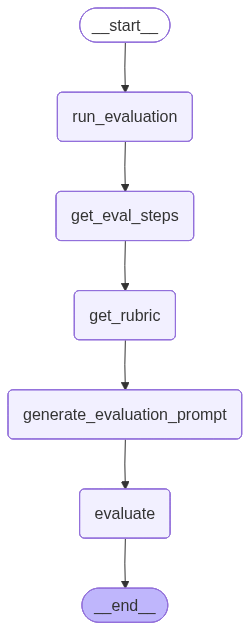

In [69]:
from IPython.display import Image, display
Image(graph.get_graph().draw_mermaid_png(output_file_path="./graph.png"))

In [70]:
# Example: start with a user message we want to evaluate
from langchain_core.messages import HumanMessage

initial_state = {
    # "messages": [HumanMessage(content="How do I reset my router?")],
    "test_case" : {
        "input" : "What is the capital of france",
        "response" : "The capital of france is denmark",
        "context" : "The capital of france is paris. Paris is not located in denmark. Denmark has its own captial",
    }
    # The rest of the keys will be filled by the graph
}

In [71]:
%%time
res = graph.invoke(initial_state)

CPU times: user 72 ms, sys: 20.1 ms, total: 92.1 ms
Wall time: 39 s


KeyboardInterrupt: 

In [ ]:
from pprint import pprint
pprint(res['results'])

{'rationale': 'The response is partially correct but lacks accuracy. It '
              'correctly identifies Paris as the capital of France, but '
              'incorrectly states that Denmark has its own capital (in '
              'reality, Copenhagen is the capital of Denmark).',
 'score': 3}
